In [80]:
#import modules
!pip install nltk
from google.colab import files
import pandas as pd
import io
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize,RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics #accuracy calculation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
#@title
from google.colab import drive
def mount_drive():
  drive.mount("/content/drive")

def load_subreddit_data(filename="reddit_train.csv"):
  uploaded = files.upload()
  return pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/reddit_train.csv", encoding = 'latin1')
X

,Unnamed: 0,X,BODY,REMOVED
0,8756,8877,Always be wary of news articles that cite unpu...,0
1,7330,7432,The problem I have with this is that the artic...,0
2,15711,15944,"This is indicative of a typical power law, and...",0
3,1604,1625,This doesn't make sense. Chess obviously trans...,0
4,13327,13520,1. I dispute that gene engineering is burdenso...,0
...,...,...,...,...
21331,2968,3001,Without context this means absolutely nothing,0
21332,25369,26687,LPT: Vape tobacco out of a lightbulb,1
21333,8223,8338,Has there been any such studies with Adderall?...,0
21334,27902,29521,"VR will be widely used for so many ""*phobias"" ...",1


In [83]:
#Kok's preprocessing
import re
corpus = []
for i in range(len(X)):
  comment = re.sub('[^a-zA-Z]',' ', X['BODY'][i])
  comment = comment.lower().split()
  ps = PorterStemmer()
  comment = [ps.stem(word) for word in comment if not word in set(stopwords.words('english'))]
  commment = ' '.join(comment)
  corpus.append(comment)

In [84]:
X_edited = X[["REMOVED", "BODY"]]
df = X_edited
df.head()

,REMOVED,BODY
0,0,Always be wary of news articles that cite unpu...
1,0,The problem I have with this is that the artic...
2,0,"This is indicative of a typical power law, and..."
3,0,This doesn't make sense. Chess obviously trans...
4,0,1. I dispute that gene engineering is burdenso...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21336 entries, 0 to 21335
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   REMOVED  21336 non-null  int64 
 1   BODY     21336 non-null  object
dtypes: int64(1), object(1)
memory usage: 333.5+ KB


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Removed and Not Removed')

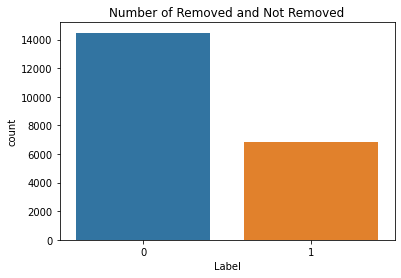

In [85]:
df.info()
sns.countplot(df.REMOVED)
plt.xlabel('Label')
plt.title('Number of Removed and Not Removed')

In [86]:
X = df.BODY
Y = df.REMOVED
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [87]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [88]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [89]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [90]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 150, 50)           50000     
_________________________________________________________________
lstm_18 (LSTM)               (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_36 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)               

In [79]:
#grid search

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
        }

def create_model():
  model = Sequential()
  model.add(Dense(12, input_dim = 150, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, scoring = scorers, refit = "accuracy_score", param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

UnimplementedError: ignored

In [93]:
#5 epochs, 128 batch size
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=5,
          validation_split=0.2)
accr3 = model.evaluate(test_sequences_matrix,Y_test)
print(accr3)
#[1.7641335725784302, 0.593564510345459]

Epoch 1/5
114/114 [==============================] - 21s 188ms/step - loss: 0.2851 - accuracy: 0.8606 - val_loss: 0.9947 - val_accuracy: 0.7022
Epoch 2/5
114/114 [==============================] - 21s 188ms/step - loss: 0.2749 - accuracy: 0.8625 - val_loss: 0.8965 - val_accuracy: 0.7091
Epoch 3/5
114/114 [==============================] - 21s 188ms/step - loss: 0.2688 - accuracy: 0.8683 - val_loss: 0.9730 - val_accuracy: 0.7077
Epoch 4/5
114/114 [==============================] - 22s 189ms/step - loss: 0.2577 - accuracy: 0.8738 - val_loss: 0.9558 - val_accuracy: 0.6981
Epoch 5/5
101/101 [==============================] - 2s 21ms/step - loss: 1.7641 - accuracy: 0.5936
[1.7641335725784302, 0.593564510345459]


In [122]:
#10 epochs, 128 batch size
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2)
accr1 = model.evaluate(test_sequences_matrix,Y_test)
print(accr1)
#[0.5863538980484009, 0.7113401889801025]
y_predict=model.predict(X_test)

Epoch 1/10
114/114 [==============================] - 22s 189ms/step - loss: 0.0304 - accuracy: 0.9943 - val_loss: 5.5172 - val_accuracy: 0.6835
Epoch 2/10
114/114 [==============================] - 22s 190ms/step - loss: 0.0198 - accuracy: 0.9940 - val_loss: 5.9595 - val_accuracy: 0.6876
Epoch 3/10
114/114 [==============================] - 21s 188ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 5.7204 - val_accuracy: 0.6884
Epoch 4/10
114/114 [==============================] - 22s 189ms/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 5.8932 - val_accuracy: 0.6840
Epoch 5/10
114/114 [==============================] - 22s 191ms/step - loss: 0.0225 - accuracy: 0.9943 - val_loss: 5.4651 - val_accuracy: 0.6650
Epoch 6/10
114/114 [==============================] - 22s 192ms/step - loss: 0.0195 - accuracy: 0.9948 - val_loss: 5.8371 - val_accuracy: 0.6970
Epoch 7/10
114/114 [==============================] - 22s 192ms/step - loss: 0.0247 - accuracy: 0.9935 - val_loss: 5.7530 - val_ac

UnimplementedError: ignored

In [91]:
#20 epochs, 128 batch size
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=20,
          validation_split=0.2)
accr2 = model.evaluate(test_sequences_matrix,Y_test)
print(accr2)
#[1.2474102973937988, 0.5851296186447144]

Epoch 1/20
114/114 [==============================] - 22s 195ms/step - loss: 0.5636 - accuracy: 0.7062 - val_loss: 0.5200 - val_accuracy: 0.7375
Epoch 2/20
114/114 [==============================] - 22s 190ms/step - loss: 0.5106 - accuracy: 0.7383 - val_loss: 0.5232 - val_accuracy: 0.7257
Epoch 3/20
114/114 [==============================] - 22s 190ms/step - loss: 0.4991 - accuracy: 0.7473 - val_loss: 0.5110 - val_accuracy: 0.7375
Epoch 4/20
114/114 [==============================] - 22s 190ms/step - loss: 0.4884 - accuracy: 0.7548 - val_loss: 0.5106 - val_accuracy: 0.7392
Epoch 5/20
114/114 [==============================] - 22s 189ms/step - loss: 0.4773 - accuracy: 0.7643 - val_loss: 0.5140 - val_accuracy: 0.7403
Epoch 6/20
114/114 [==============================] - 21s 187ms/step - loss: 0.4647 - accuracy: 0.7721 - val_loss: 0.5206 - val_accuracy: 0.7345
Epoch 7/20
114/114 [==============================] - 25s 217ms/step - loss: 0.4530 - accuracy: 0.7778 - val_loss: 0.5313 - val_ac

In [94]:
#5 epochs, 64 batch size
model.fit(sequences_matrix,Y_train,batch_size=64,epochs=5,
          validation_split=0.2)
accr4 = model.evaluate(test_sequences_matrix,Y_test)
print(accr4)
#[1.7968050241470337, 0.5945017337799072]

Epoch 1/5
227/227 [==============================] - 30s 133ms/step - loss: 0.2579 - accuracy: 0.8721 - val_loss: 1.0827 - val_accuracy: 0.7102
Epoch 2/5
227/227 [==============================] - 29s 126ms/step - loss: 0.2554 - accuracy: 0.8757 - val_loss: 1.1321 - val_accuracy: 0.6802
Epoch 3/5
227/227 [==============================] - 28s 123ms/step - loss: 0.2428 - accuracy: 0.8810 - val_loss: 1.2902 - val_accuracy: 0.6984
Epoch 4/5
227/227 [==============================] - 28s 122ms/step - loss: 0.2368 - accuracy: 0.8812 - val_loss: 1.2265 - val_accuracy: 0.6829
Epoch 5/5
101/101 [==============================] - 2s 20ms/step - loss: 1.7968 - accuracy: 0.5945
[1.7968050241470337, 0.5945017337799072]


In [95]:
#10 epochs, 64 batch size
model.fit(sequences_matrix,Y_train,batch_size=64,epochs=10,
          validation_split=0.2)
accr5 = model.evaluate(test_sequences_matrix,Y_test)
print(accr5)
#[3.190030097961426, 0.5673227310180664]

Epoch 1/10
227/227 [==============================] - 27s 120ms/step - loss: 0.2229 - accuracy: 0.8921 - val_loss: 1.3279 - val_accuracy: 0.6978
Epoch 2/10
227/227 [==============================] - 28s 122ms/step - loss: 0.2123 - accuracy: 0.8972 - val_loss: 1.3393 - val_accuracy: 0.6725
Epoch 3/10
227/227 [==============================] - 27s 121ms/step - loss: 0.2047 - accuracy: 0.9027 - val_loss: 1.3828 - val_accuracy: 0.6832
Epoch 4/10
227/227 [==============================] - 28s 122ms/step - loss: 0.1897 - accuracy: 0.9078 - val_loss: 1.5025 - val_accuracy: 0.6931
Epoch 5/10
227/227 [==============================] - 28s 124ms/step - loss: 0.1893 - accuracy: 0.9101 - val_loss: 1.6223 - val_accuracy: 0.6543
Epoch 6/10
227/227 [==============================] - 27s 121ms/step - loss: 0.1786 - accuracy: 0.9176 - val_loss: 1.5649 - val_accuracy: 0.6978
Epoch 7/10
227/227 [==============================] - 28s 121ms/step - loss: 0.1758 - accuracy: 0.9200 - val_loss: 1.6444 - val_ac

In [96]:
#20 epochs, 64 batch size
model.fit(sequences_matrix,Y_train,batch_size=64,epochs=20,
          validation_split=0.2)
accr6 = model.evaluate(test_sequences_matrix,Y_test)
print(accr6)
#[5.0754780769348145, 0.5729459524154663]

Epoch 1/20
227/227 [==============================] - 28s 122ms/step - loss: 0.1423 - accuracy: 0.9373 - val_loss: 2.1098 - val_accuracy: 0.6755
Epoch 2/20
227/227 [==============================] - 28s 123ms/step - loss: 0.1368 - accuracy: 0.9380 - val_loss: 2.1240 - val_accuracy: 0.6793
Epoch 3/20
227/227 [==============================] - 27s 121ms/step - loss: 0.1389 - accuracy: 0.9408 - val_loss: 2.2119 - val_accuracy: 0.6810
Epoch 4/20
227/227 [==============================] - 28s 122ms/step - loss: 0.1327 - accuracy: 0.9436 - val_loss: 2.1963 - val_accuracy: 0.6755
Epoch 5/20
227/227 [==============================] - 28s 122ms/step - loss: 0.1236 - accuracy: 0.9471 - val_loss: 2.2826 - val_accuracy: 0.6967
Epoch 6/20
227/227 [==============================] - 28s 121ms/step - loss: 0.1108 - accuracy: 0.9517 - val_loss: 2.3911 - val_accuracy: 0.6785
Epoch 7/20
227/227 [==============================] - 28s 122ms/step - loss: 0.1147 - accuracy: 0.9540 - val_loss: 2.5540 - val_ac

In [97]:
#10 epochs, 256 batch size
model.fit(sequences_matrix,Y_train,batch_size=256,epochs=10,
          validation_split=0.2)
accr7 = model.evaluate(test_sequences_matrix,Y_test)
print(accr7)
#[7.178565502166748, 0.5779443979263306]

Epoch 1/10
57/57 [==============================] - 25s 431ms/step - loss: 0.0446 - accuracy: 0.9839 - val_loss: 3.7237 - val_accuracy: 0.6890
Epoch 2/10
57/57 [==============================] - 25s 446ms/step - loss: 0.0440 - accuracy: 0.9829 - val_loss: 3.7279 - val_accuracy: 0.6843
Epoch 3/10
57/57 [==============================] - 25s 430ms/step - loss: 0.0401 - accuracy: 0.9855 - val_loss: 3.8411 - val_accuracy: 0.6818
Epoch 4/10
57/57 [==============================] - 25s 431ms/step - loss: 0.0354 - accuracy: 0.9868 - val_loss: 3.9707 - val_accuracy: 0.6802
Epoch 5/10
57/57 [==============================] - 25s 439ms/step - loss: 0.0354 - accuracy: 0.9862 - val_loss: 4.0106 - val_accuracy: 0.6675
Epoch 6/10
57/57 [==============================] - 25s 434ms/step - loss: 0.0350 - accuracy: 0.9870 - val_loss: 4.1455 - val_accuracy: 0.6829
Epoch 7/10
57/57 [==============================] - 25s 430ms/step - loss: 0.0354 - accuracy: 0.9872 - val_loss: 4.2329 - val_accuracy: 0.6896

In [98]:
#20 epochs, 256 batch size
model.fit(sequences_matrix,Y_train,batch_size=256,epochs=20,
          validation_split=0.2)
accr8 = model.evaluate(test_sequences_matrix,Y_test)
print(accr8)
#[8.156317710876465, 0.5726335644721985]

Epoch 1/20
57/57 [==============================] - 25s 441ms/step - loss: 0.0297 - accuracy: 0.9888 - val_loss: 4.6328 - val_accuracy: 0.6816
Epoch 2/20
57/57 [==============================] - 25s 433ms/step - loss: 0.0347 - accuracy: 0.9895 - val_loss: 4.5642 - val_accuracy: 0.6816
Epoch 3/20
57/57 [==============================] - 25s 434ms/step - loss: 0.0306 - accuracy: 0.9902 - val_loss: 4.6838 - val_accuracy: 0.6816
Epoch 4/20
57/57 [==============================] - 25s 434ms/step - loss: 0.0253 - accuracy: 0.9911 - val_loss: 4.8158 - val_accuracy: 0.6769
Epoch 5/20
57/57 [==============================] - 26s 459ms/step - loss: 0.0319 - accuracy: 0.9909 - val_loss: 4.7809 - val_accuracy: 0.6835
Epoch 6/20
57/57 [==============================] - 25s 439ms/step - loss: 0.0240 - accuracy: 0.9914 - val_loss: 4.9830 - val_accuracy: 0.6865
Epoch 7/20
57/57 [==============================] - 25s 433ms/step - loss: 0.0269 - accuracy: 0.9910 - val_loss: 5.2652 - val_accuracy: 0.6873

In [102]:
#5 epochs, 256 batch size
model.fit(sequences_matrix,Y_train,batch_size=256,epochs=5,
          validation_split=0.2)
accr9 = model.evaluate(test_sequences_matrix,Y_test)
print(accr9)
#[8.532583236694336, 0.5723211765289307]

Epoch 1/5
57/57 [==============================] - 25s 438ms/step - loss: 0.0257 - accuracy: 0.9946 - val_loss: 5.6455 - val_accuracy: 0.6813
Epoch 2/5
57/57 [==============================] - 26s 455ms/step - loss: 0.0177 - accuracy: 0.9950 - val_loss: 6.0171 - val_accuracy: 0.6829
Epoch 3/5
57/57 [==============================] - 25s 436ms/step - loss: 0.0133 - accuracy: 0.9961 - val_loss: 5.8092 - val_accuracy: 0.6851
Epoch 4/5
57/57 [==============================] - 25s 431ms/step - loss: 0.0298 - accuracy: 0.9936 - val_loss: 5.7024 - val_accuracy: 0.6805
Epoch 5/5
101/101 [==============================] - 2s 23ms/step - loss: 8.5326 - accuracy: 0.5723
[8.532583236694336, 0.5723211765289307]


In [29]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [30]:
accr = model.evaluate(test_sequences_matrix,Y_test)
print(accr)

101/101 [==============================] - 2s 21ms/step - loss: 0.5864 - accuracy: 0.7113
[0.5863538980484009, 0.7113401889801025]


         64        128       256
5   0.634502  0.626451  0.582321
10  0.667323  0.687340  0.577944
20  0.582946  0.572962  0.572634


Text(33.0, 0.5, 'Number of Epochs')

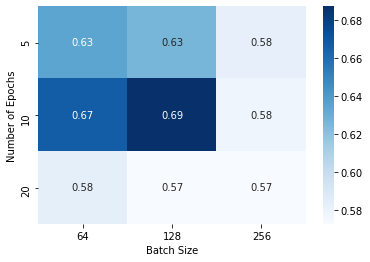

In [121]:
#df = pd.DataFrame({"Number of Epochs" : [5, 10, 20], "Batch Size" : [64, 128, 256, 64, 128, 256, 64, 128, 256] , "Accuracy": [0.5945017337799072,0.5673227310180664,0.5729459524154663, 0.593564510345459, 0.7113401889801025, 0.5851296186447144, 0.5723211765289307, 0.5779443979263306, 0.5726335644721985]})
import seaborn as sns

df = pd.DataFrame({64: [0.6345017337799072,0.6673227310180664,0.5829459524154663], 128: [0.6264510345459, 0.6873401889801025, 0.57296186447144], 256: [0.5823211765289307, 0.5779443979263306, 0.5726335644721985]})
df.rename(index={0: 5, 1: 10, 2: 20}, inplace=True)
print(df)

sns.heatmap(df, annot=True, cmap='Blues')
plt.xlabel("Batch Size")
plt.ylabel("Number of Epochs")
